In [1]:
%run -i ./preamble.py
%config InlineBackend.figure_format = 'retina'
%load_ext nb_black

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import sys, pandas

print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("PyMC3 version:", pm.__version__)
print("Arviz version:", arviz.__version__)
print("Pandas version:", pandas.__version__)

tic()

Python version: 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 15:45:16) 
[GCC 9.3.0]
Numpy version: 1.20.2
PyMC3 version: 3.11.2
Arviz version: 0.11.2
Pandas version: 1.2.3


In [3]:
FAST = False

# Processor information and SMC calibration parameters
if not FAST:
    numIters = 15
    popSize = 1000
    epsMin = 0
else:
    numIters = 5
    popSize = 100
    epsMin = 0

smcArgs = {"epsMin": epsMin, "verbose": True}
smcArgs["numProcs"] = 64

# Time dependent: nonhomogenous Poisson process with seasonality

The claim arrival process is governed by a non homogenous Poisson process $N_t$ with intensity function 

$$
\lambda(t) = b[\sin(2\pi c t) + 1]
$$

The claim frequency data $n_s,\,s = 1,\ldots, t$ correspond to the increments of this non homogeneous Poisson process. These are independent Poisson variables $\text{Pois}[\mu(s)]$ with 

$$
\mu(s) = \int_{s-1}^s\lambda(u)du = b + \frac{b}{2\pi c}\left[\cos(2\pi(s-1) c) - \cos(2\pi s c)\right],\quad s = 1,\ldots, t
$$



In [4]:
rg = default_rng(123)
sample_sizes = [50, 250]
T = sample_sizes[-1]

a, b, c, μ, σ = 1, 5, 1 / 50, 0, 0.5

θ_True = a, b, c, μ, σ

freq, sev, theta = "cyclical_poisson", "lognormal", [a, b, c, μ, σ]

freqs, sevs = abcre.simulate_claim_data(rg, T, freq, sev, theta)

# Aggregation process
psi = abcre.Psi("sum")

xData = abcre.compute_psi(freqs, sevs, psi)

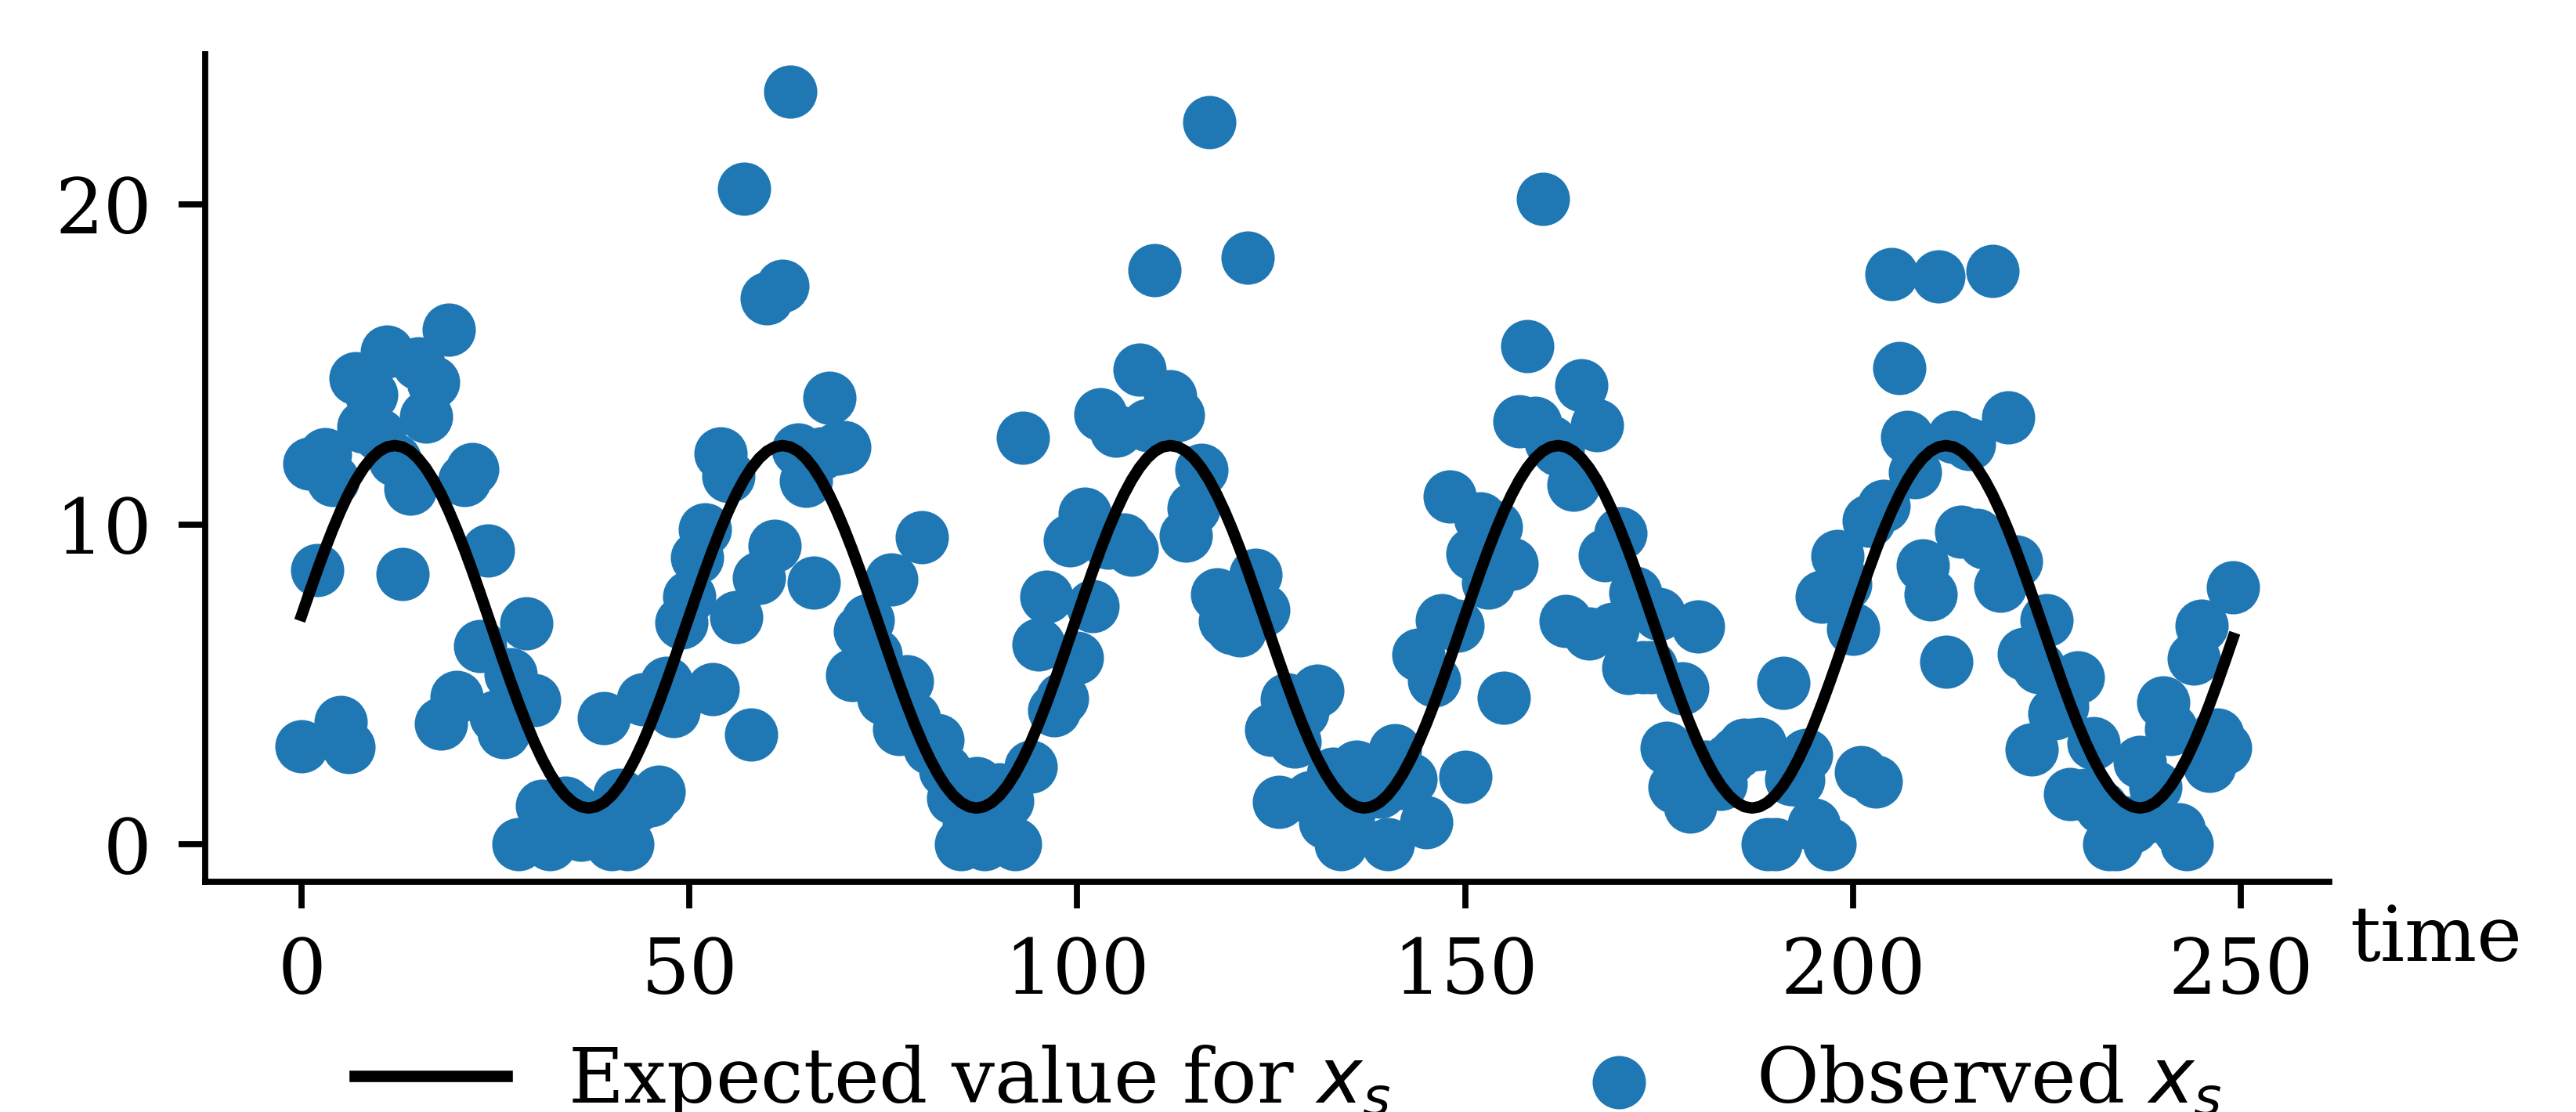

In [5]:
t = np.arange(T)
mus = (
    a
    + b
    + b * (np.cos(2 * np.pi * t * c) - np.cos(2 * np.pi * (t + 1) * c)) / 2 / np.pi / c
)
expXs = np.exp(μ + σ ** 2 / 2) * mus
# expXs = μ * mus
fig, ax = plt.subplots()
ax.plot(t, expXs, label="Expected value for $x_s$", c="k")
ax.scatter(t, xData, label="Observed $x_s$")
ax.set(xlabel="time", title="")
ax.xaxis.set_label_coords(1.05, -0.025)
# ax.grid()
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, ncol=2, borderaxespad=-0.5, loc="lower center", frameon=False
)
sns.despine()
save_cropped("../Figures/cyclical_poisson_lognormal_data.pdf")

In [6]:
params = ("a", "b", "c", "\mu", "\sigma")
prior = abcre.IndependentUniformPrior(
    [(0, 50), (0, 50), (1 / 1000, 1 / 10), (-10, 10), (0, 3)]
)
model = abcre.Model("cyclical_poisson", "lognormal", psi, prior)

# ABC posterior when exactly matching the time indices

In [7]:
AR = 1
dfABC = pd.DataFrame()

for ss in sample_sizes:
    xDataSS = xData[:ss]

    scale_x = 100
    scale_t = scale_x * (np.max(xData ) - np.min(xData )) / (ss - 1) * AR


    %time fit1 = abcre.smc(numIters, popSize, xDataSS, model, sumstats=abcre.identity, **smcArgs)
    %time fit2 = abcre.smc(numIters, popSize, xDataSS, model, sumstats=abcre.wrap_ss_curve_matching(scale_x, scale_t),\
                          distance=abcre.wass_2Ddist, **smcArgs)
    %time fit3 = abcre.smc(numIters, popSize, xDataSS, model, **smcArgs)
    fits = (fit1,fit2, fit3)

    
    distances = ["L1", "curve_matching", "sorted_data"]
    for k, fit in enumerate(fits):

        columns = {
            "ss": np.repeat(ss, popSize),
            "weights": fit.weights,
            "distance": np.repeat(distances[k], popSize),
        }

        for i, param in enumerate(params):
            columns[param] = fit.samples[:, i]

        res = pd.DataFrame(columns)

        dfABC = pd.concat([dfABC, res])


Final population dists <= 2.12, ESS = 757
CPU times: user 26.6 s, sys: 1.52 s, total: 28.2 s
Wall time: 38.8 s


Final population dists <= 216.35, ESS = 569
CPU times: user 23.9 s, sys: 825 ms, total: 24.8 s
Wall time: 1min 3s


Final population dists <= 0.53, ESS = 659
CPU times: user 28.7 s, sys: 1.34 s, total: 30.1 s
Wall time: 1min 11s


Final population dists <= 2.42, ESS = 730
CPU times: user 26.9 s, sys: 1.19 s, total: 28.1 s
Wall time: 56.4 s


Final population dists <= 214.41, ESS = 535
CPU times: user 33.9 s, sys: 1.31 s, total: 35.2 s
Wall time: 7min 51s


Final population dists <= 0.22, ESS = 776
CPU times: user 28.5 s, sys: 1.42 s, total: 29.9 s
Wall time: 1min 20s


# Plots to compare the posterior distribution based on different distance for a given sample size

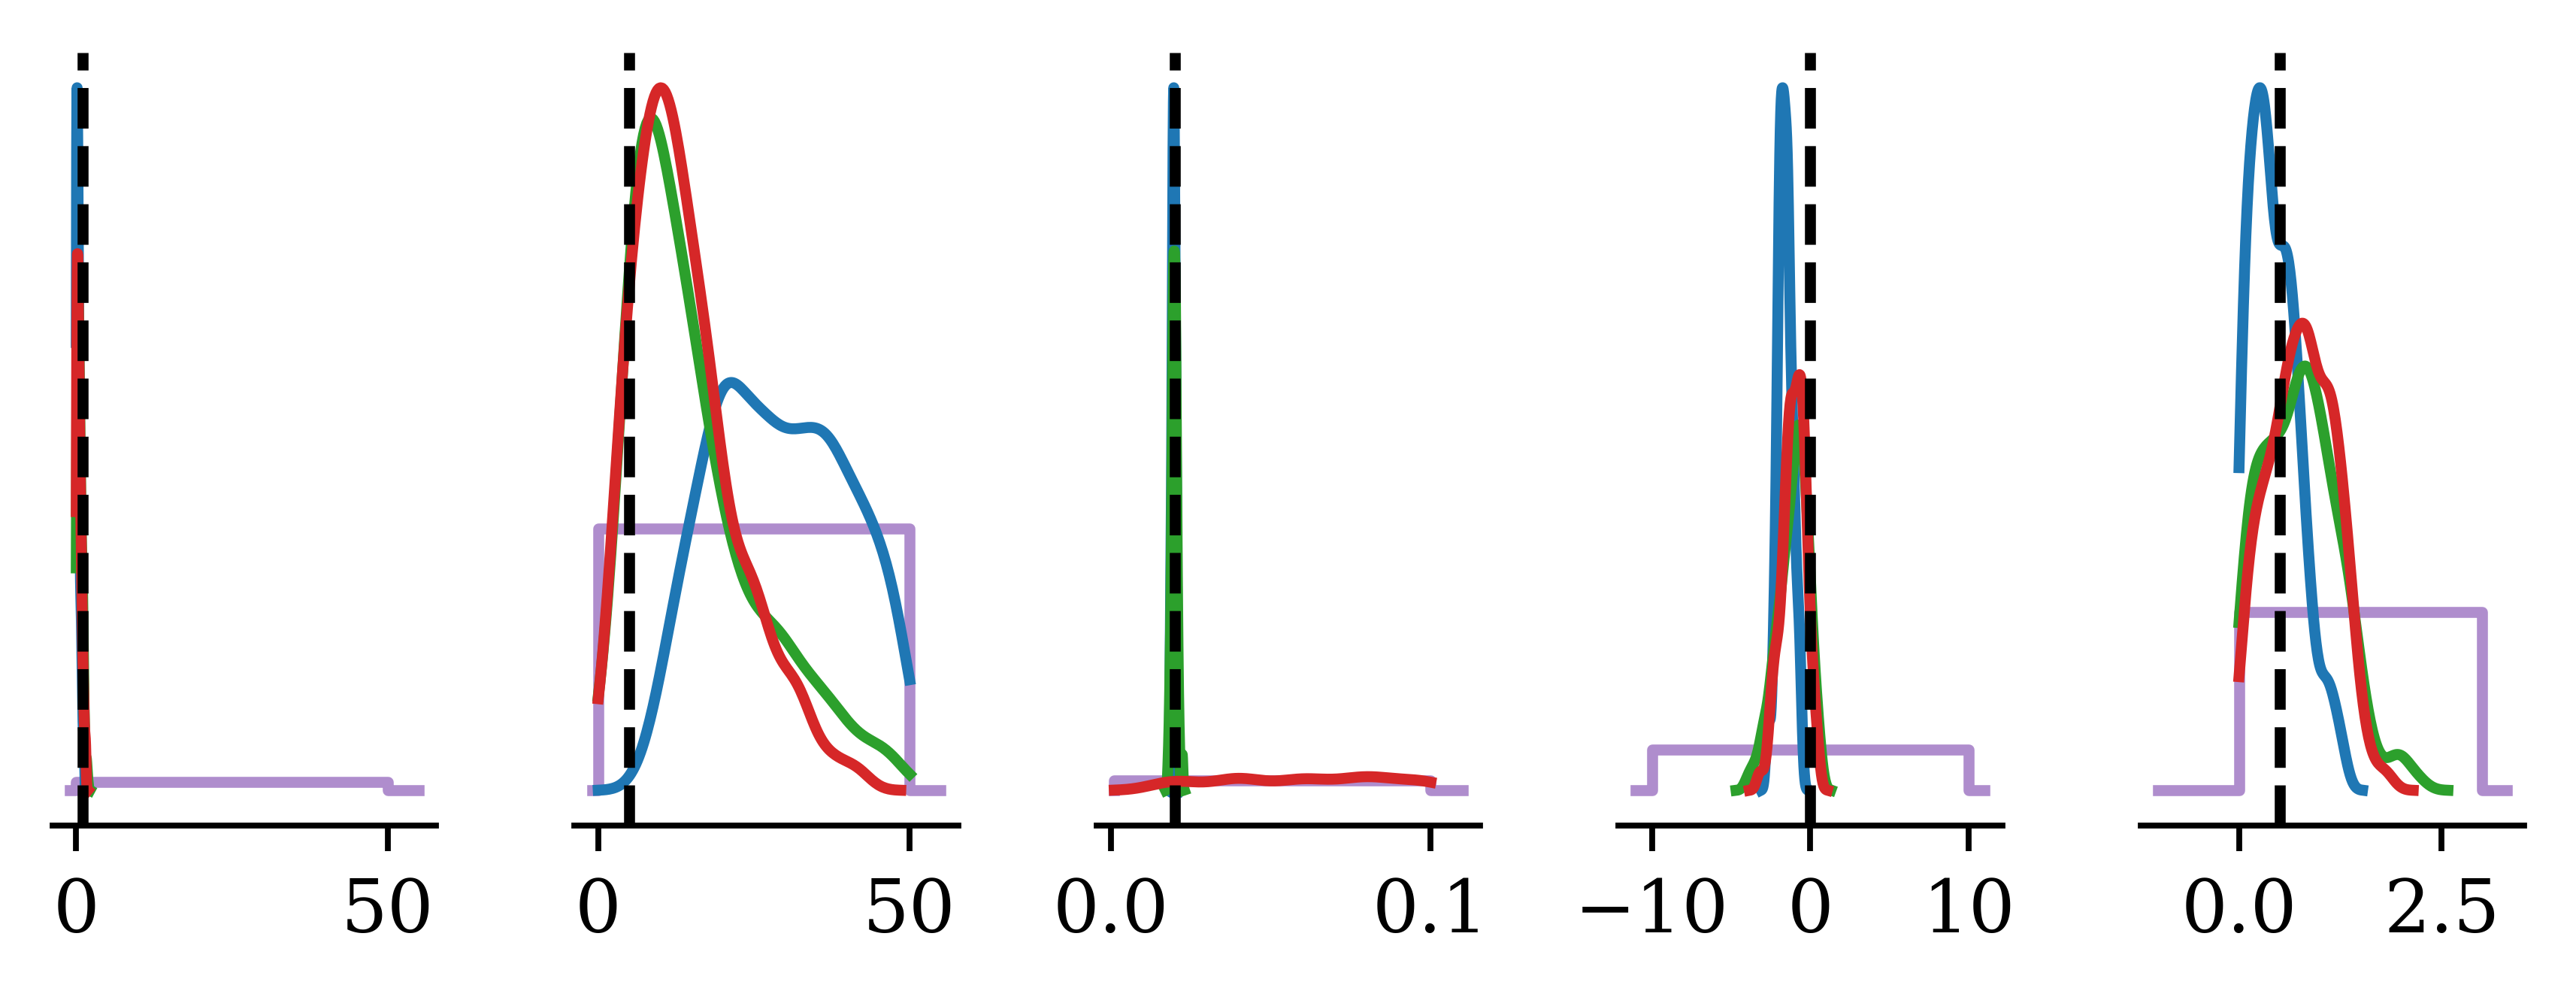

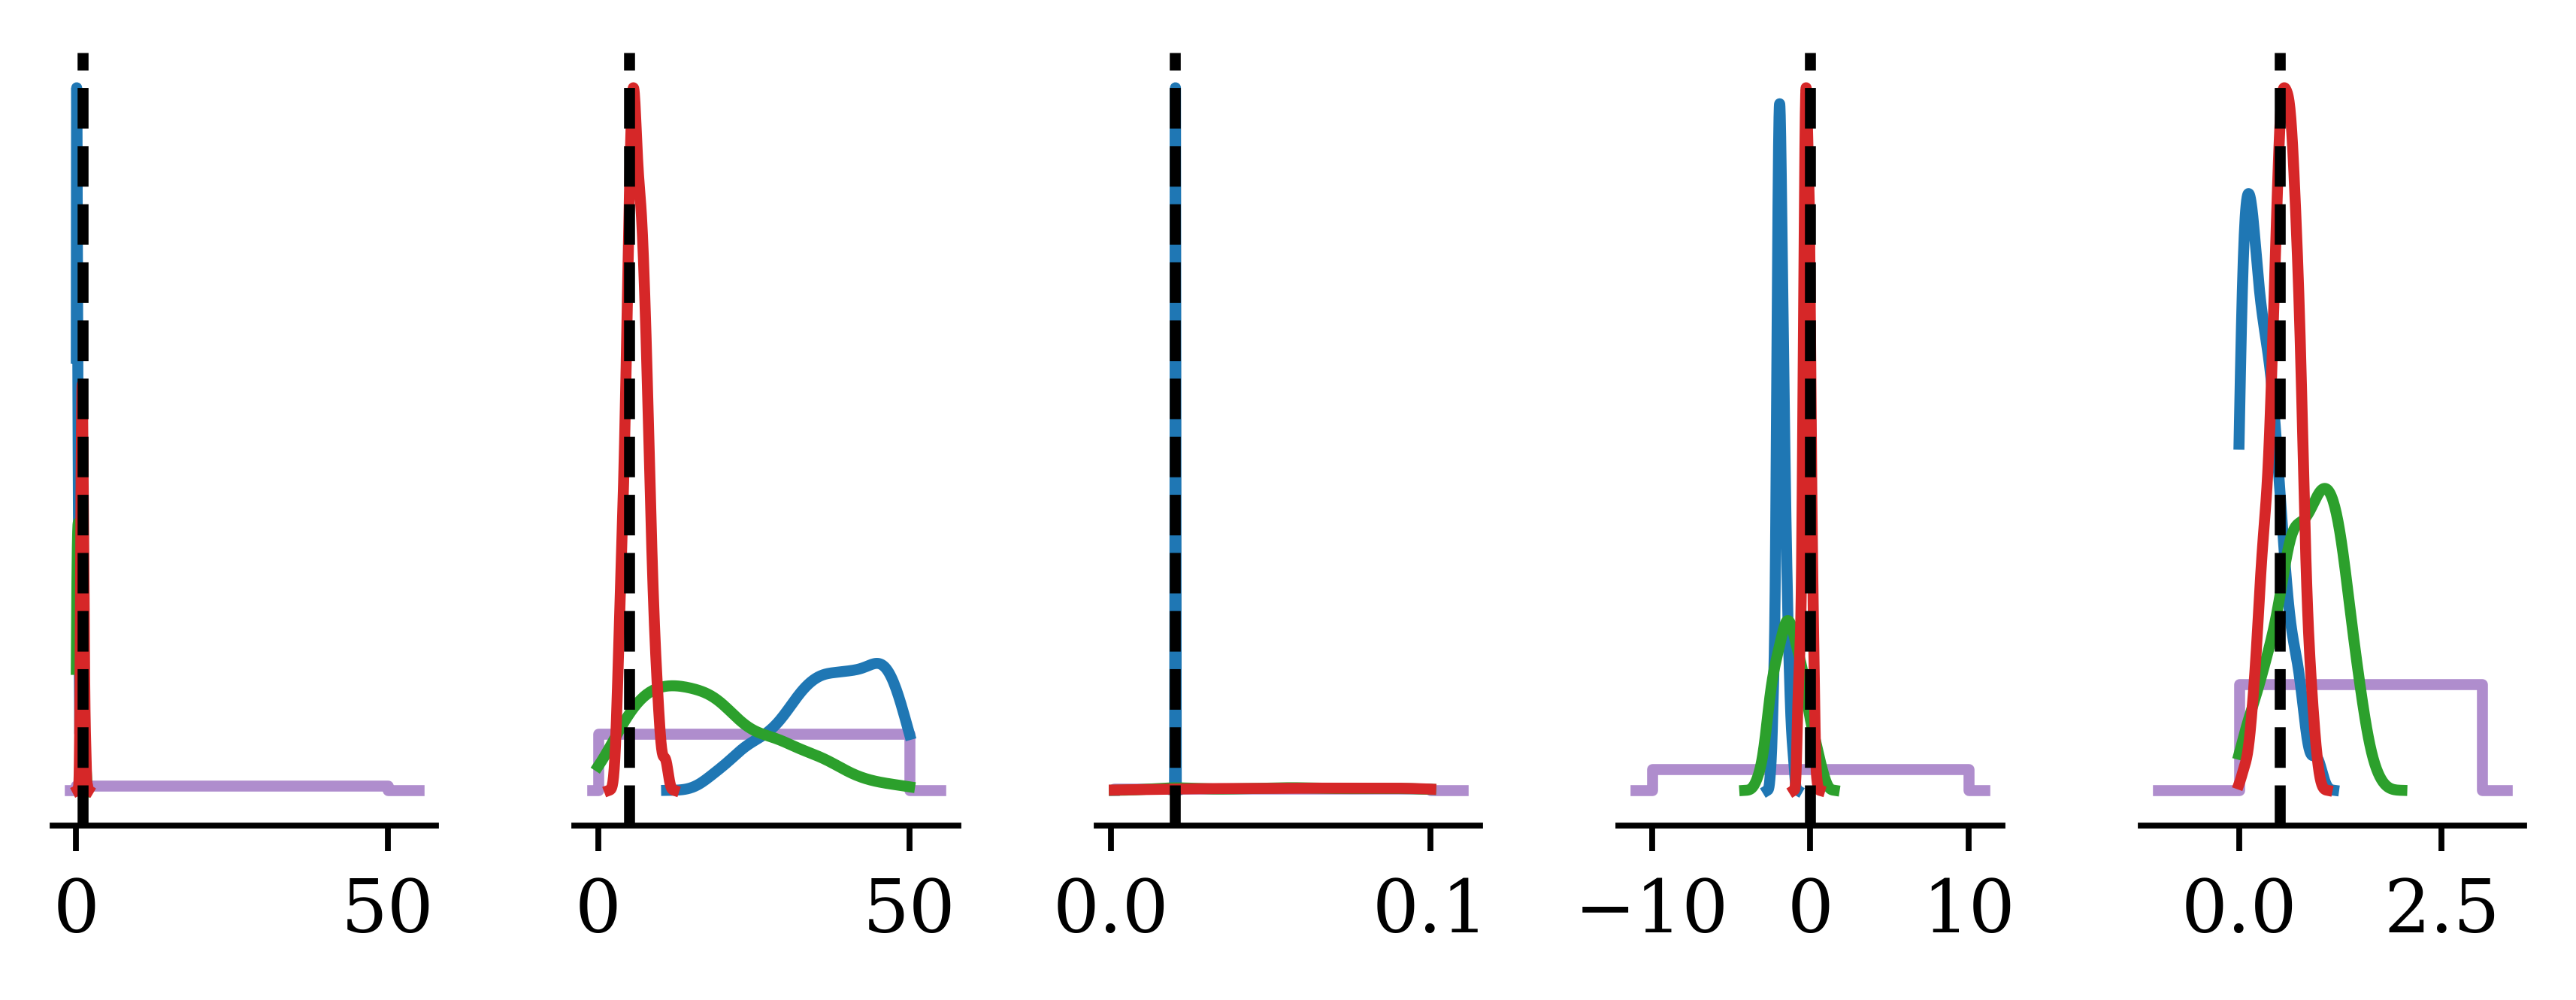

In [8]:
for ss in sample_sizes:
    #     ss = sample_sizes[2]
    fig, axs = plt.subplots(1, len(params), tight_layout=True)

    for l in range(len(params)):
        pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
        #         axs[l].set_xlim(pLims)

        for k, distance in enumerate(distances):
            sampleData = dfABC.query("distance == @distance").query("ss == @ss")
            sample = sampleData[params[l]]
            weights = sampleData["weights"]

            dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label=distance)

        axs[l].axvline(θ_True[l], **trueStyle)
        #     axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

    draw_prior(prior, axs)
    sns.despine(left=True)
    plt.show()
    #     plt.savefig("../Figures/hist-cyclical-poisson-lnorm-T" + str(ss) + ".pdf")
#     save_cropped("../Figures/hist-cyclical-poisson-lnorm-T" + str(ss) + ".pdf")

# Combining the L1 and L1 on sorted data posteriors

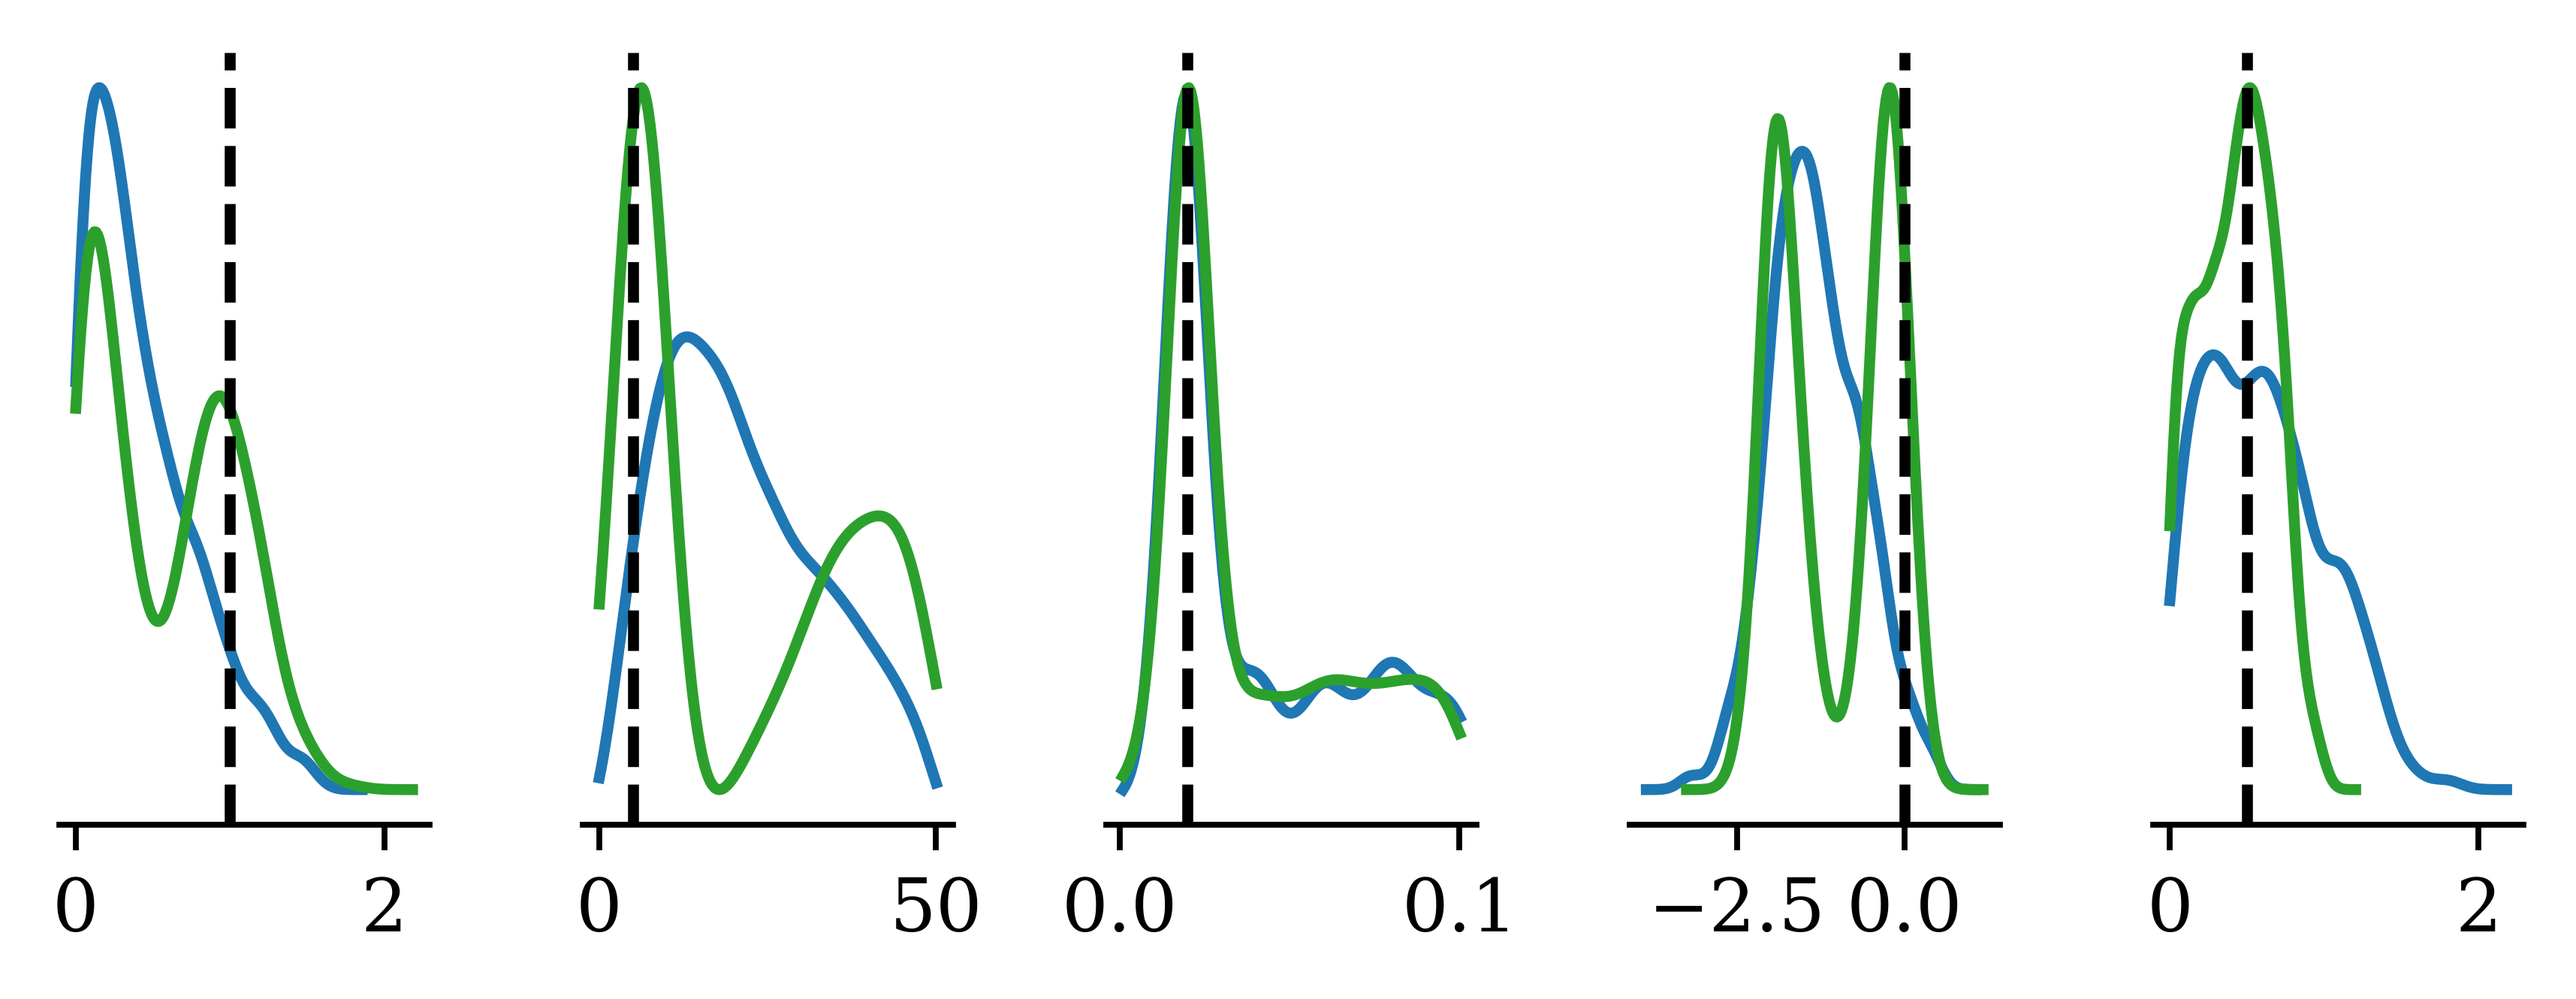

In [9]:
fig, axs = plt.subplots(1, len(params), tight_layout=True)
dfABC_new = dfABC.iloc[
    np.array(dfABC.distance == "sorted_data") | np.array(dfABC.distance == "L1")
]

for l in range(len(params)):
    pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
    # axs[l].set_xlim(pLims)

    for k, ss in enumerate(sample_sizes):
        sampleData = dfABC_new.query("ss == @ss")

        sample = sampleData[params[l]]

        weights = sampleData["weights"]

        dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
        axs[l].plot(xs, ys, label=str(ss))

    axs[l].axvline(θ_True[l], **trueStyle)
    #     axs[l].set_title("$" + params[l] + "$")
    axs[l].set_yticks([])


# draw_prior(prior, axs)
sns.despine(left=True)
save_cropped("../Figures/hist-cyclical-poisson-lnorm-post_combination.pdf")



# Plots to compare the posterior distribution based on a specifi distance with different sample size

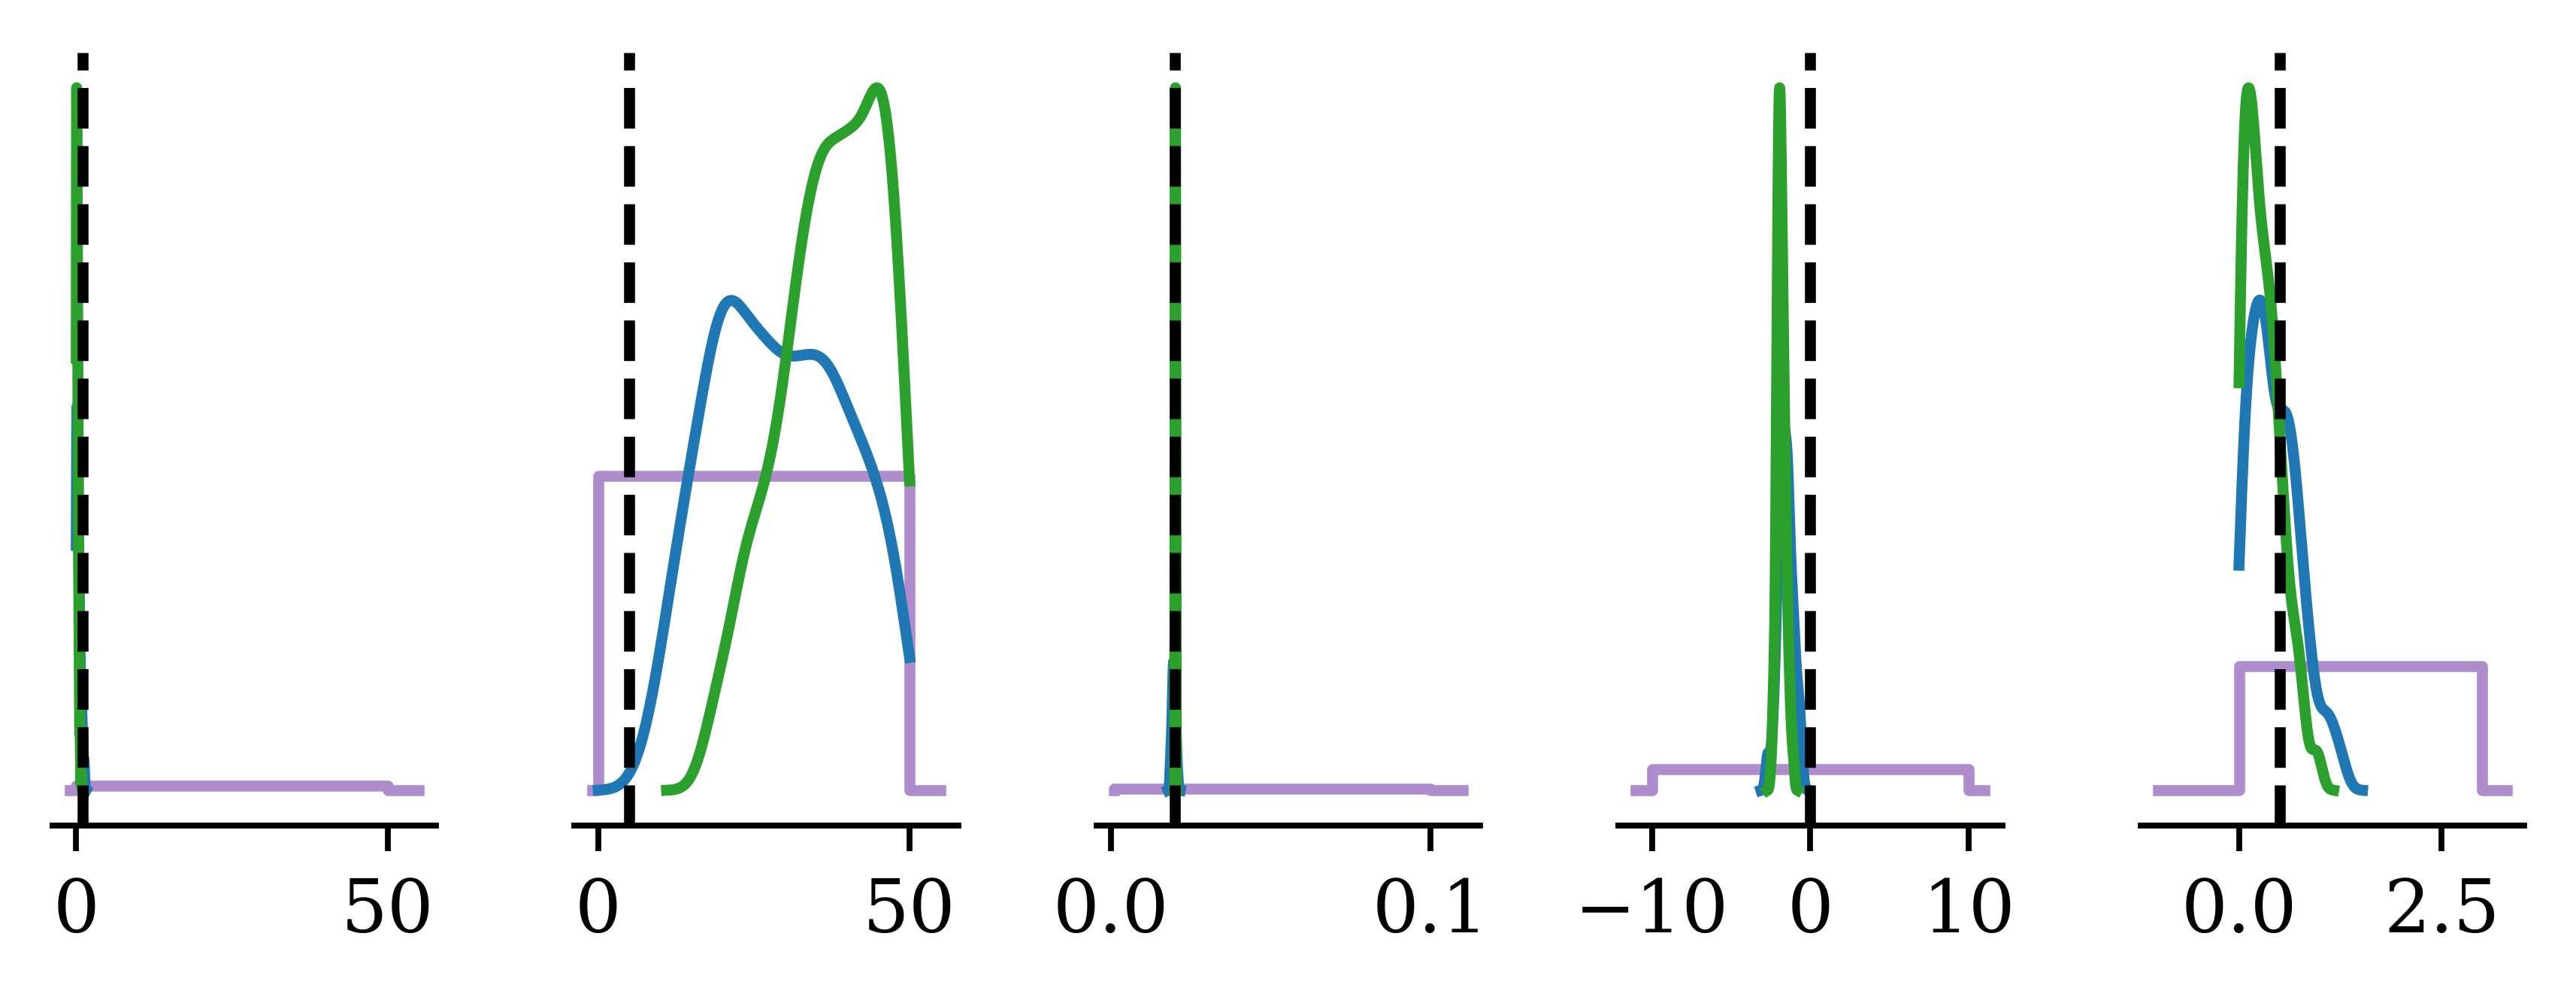

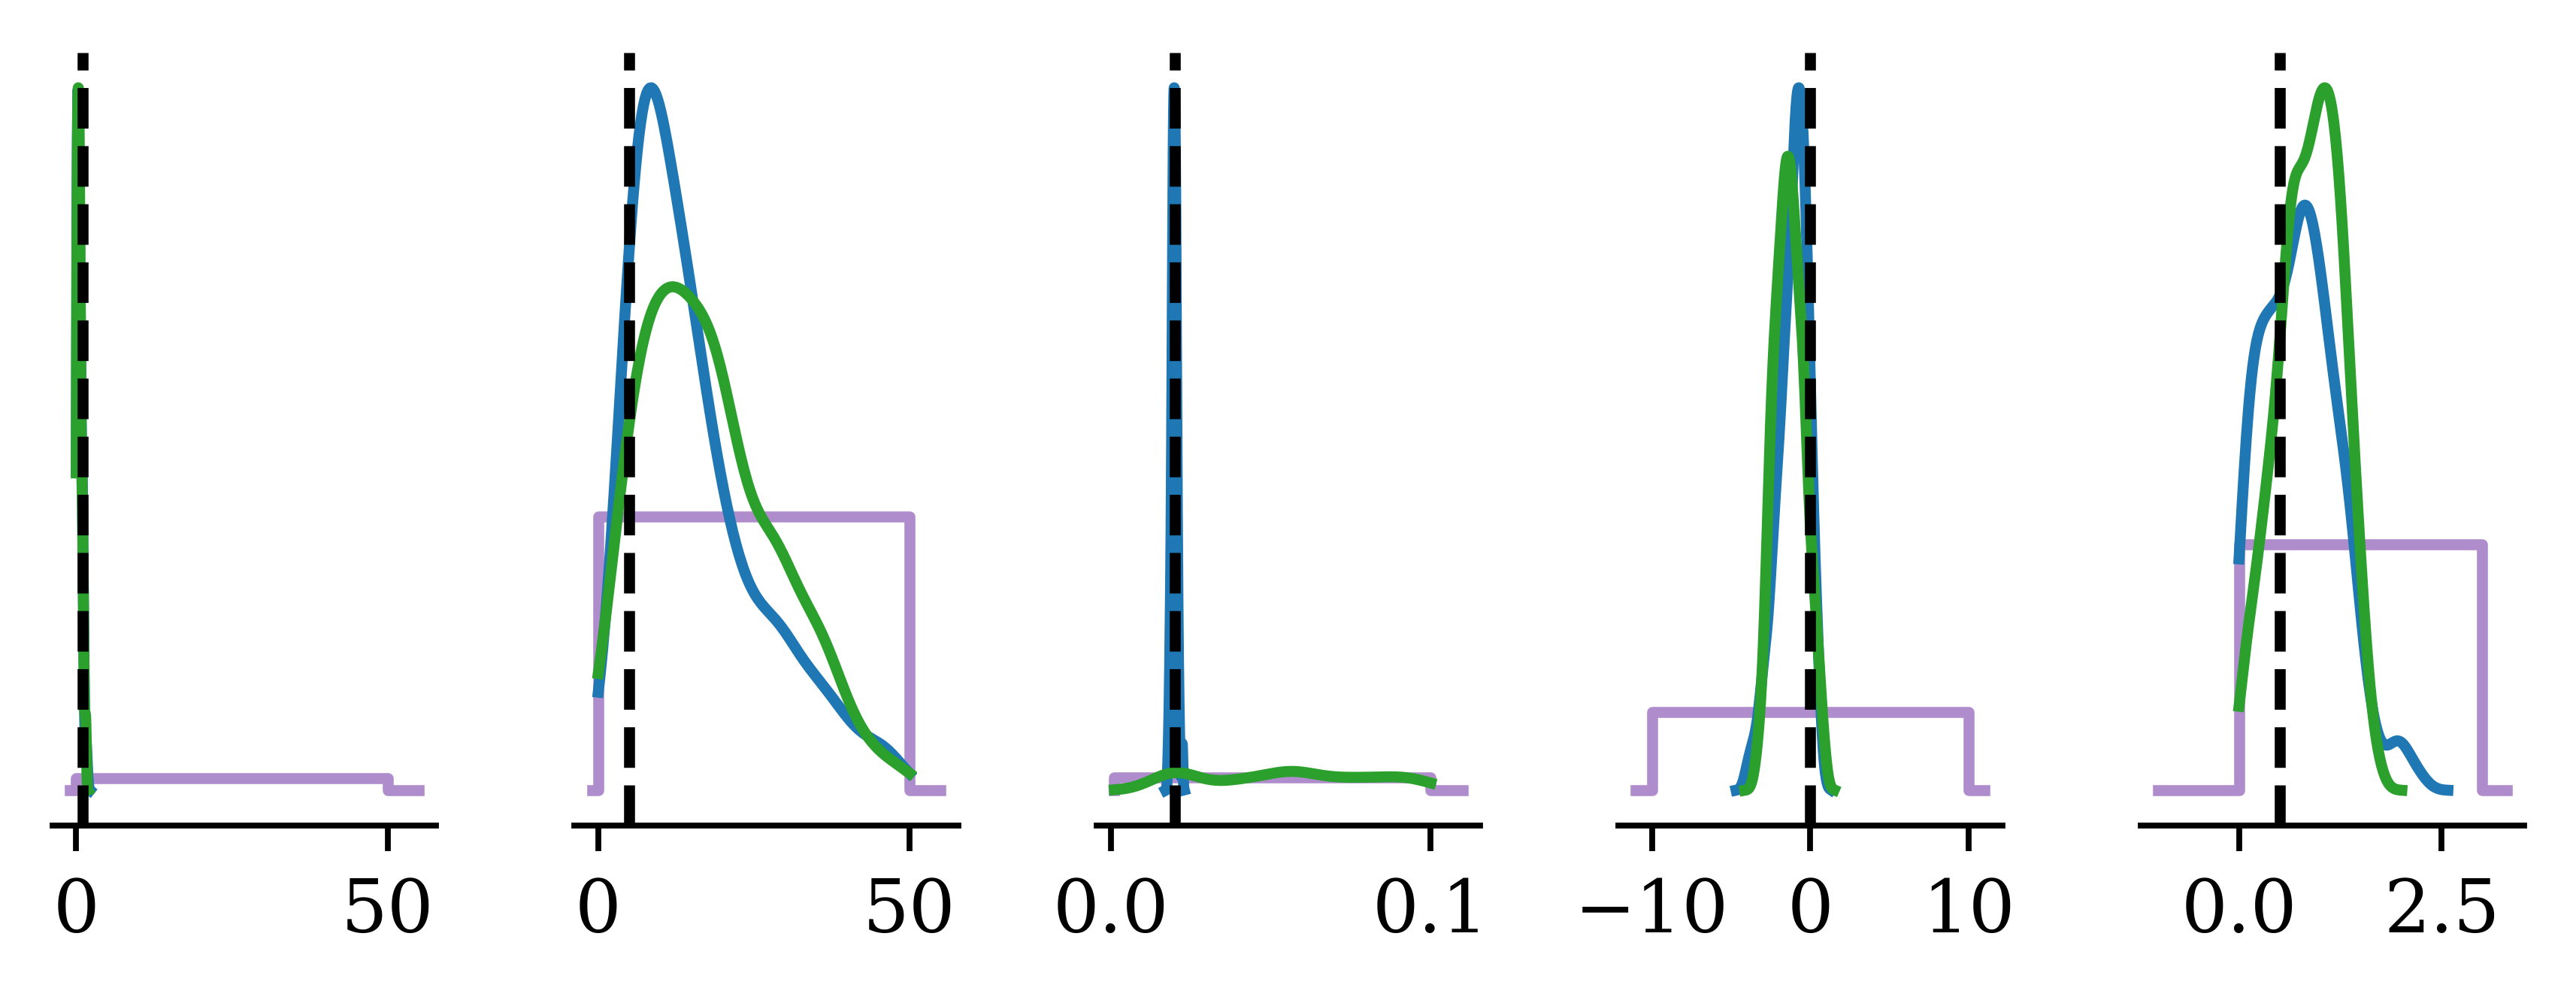

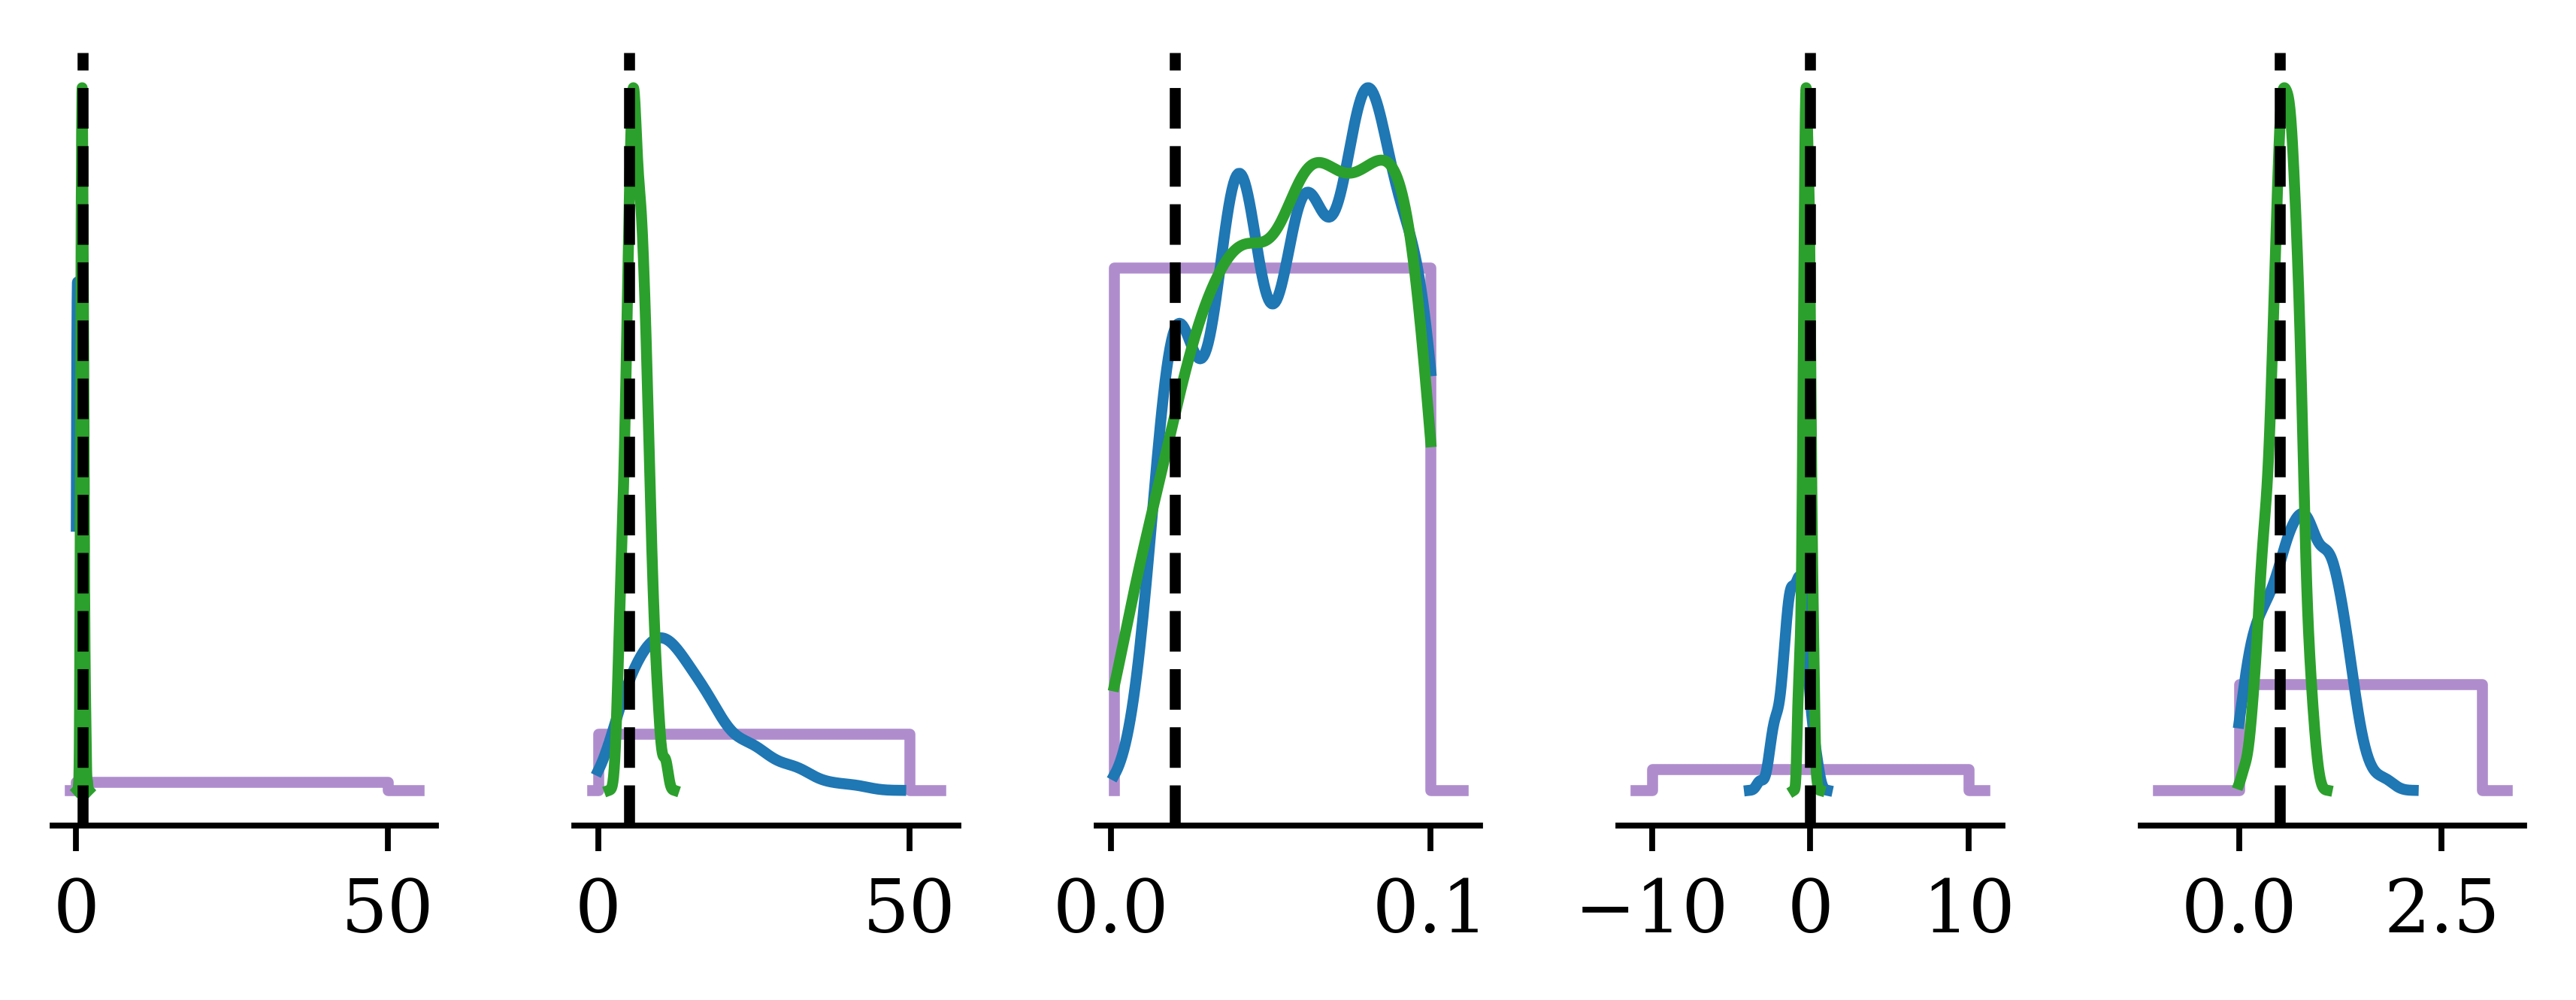

In [10]:
for distance in distances:
# distance = "L1"
    fig, axs = plt.subplots(1, len(params), tight_layout=True)

    for l in range(len(params)):
        pLims = [prior.marginals[l].isf(1), prior.marginals[l].isf(0)]
        # axs[l].set_xlim(pLims)

        for k, ss in enumerate(sample_sizes):
            sampleData = dfABC.query("ss == @ss").query("distance == @distance")
            sample = sampleData[params[l]]

            weights = sampleData["weights"]

            dataResampled, xs, ys = abcre.resample_and_kde(sample, weights, clip=pLims)
            axs[l].plot(xs, ys, label=str(ss))

        axs[l].axvline(θ_True[l], **trueStyle)
        #     axs[l].set_title("$" + params[l] + "$")
        axs[l].set_yticks([])

#     handles, labels = axs[0].get_legend_handles_labels()
#     fig.legend(
#         handles, labels, ncol=3, borderaxespad=0.0, loc="upper center", frameon=False
#     )
    draw_prior(prior, axs)
    sns.despine(left=True)
#     plt.show()
#     save_cropped("../Figures/hist-cyclical-poisson-lnorm-" + str(distance) + ".pdf")


# Recovered signal based on MAP estimators of the model parameters for a given sample size and a given distance

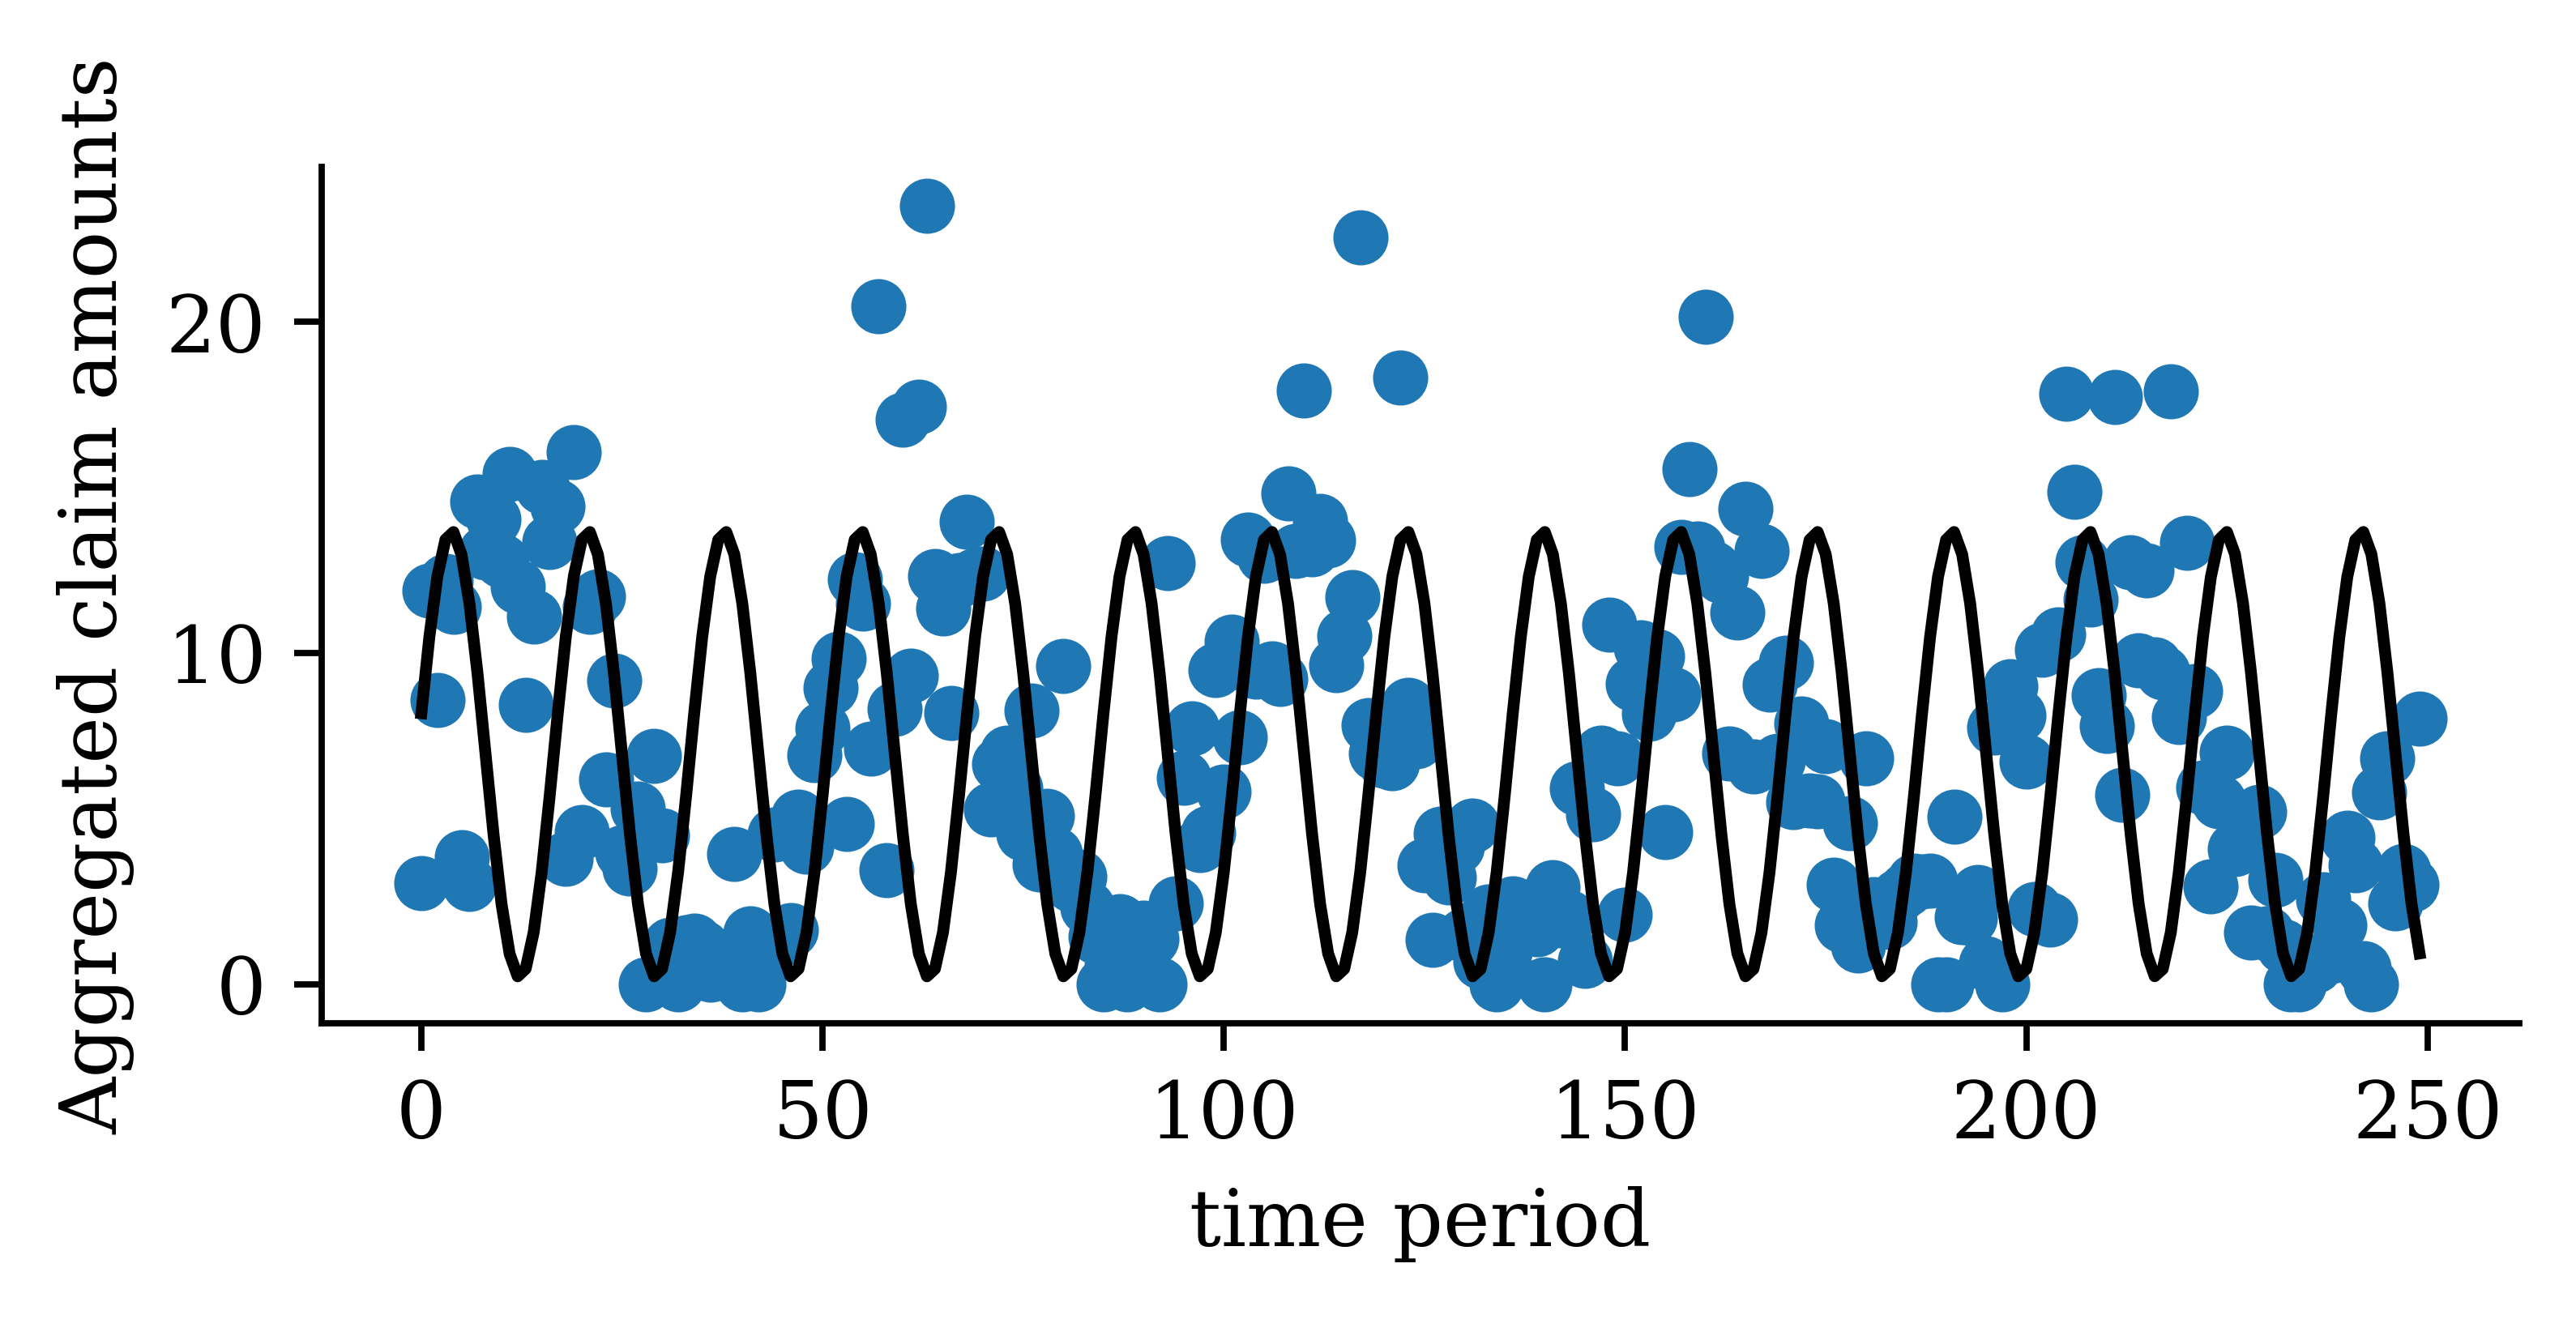

In [11]:
distance = "curve_matching"
ss = sample_sizes[1]
parms_name = ["a", "b", "c", "\mu", "\sigma"]
θ_map = (
    dfABC.query("ss == @ss").query("distance == @distance")[parms_name].mean().values
)
a, b, c, μ, σ = θ_map
t = np.arange(ss)
mus = (
    a
    + b
    + b * (np.cos(2 * np.pi * t * c) - np.cos(2 * np.pi * (t + 1) * c)) / 2 / np.pi / c
)
expXs = np.exp(μ + σ ** 2 / 2) * mus
# expXs = μ * mus
fig, ax = plt.subplots()
ax.plot(t, expXs, label="Expected value for X_s", c="k")
ax.scatter(t, xData[:ss])
ax.set(xlabel="time period", ylabel="Aggregated claim amounts", title="")
# ax.grid()
sns.despine()

In [12]:
elapsed = toc()
print(f"Notebook time = {elapsed:.0f} secs = {elapsed/60:.2f} mins")

Notebook time = 792 secs = 13.20 mins


In [13]:
dill.dump_session("Sim_Cyclical_Poisson.pkl")